In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [285]:
class trove :
    def __init__(self,_collateral,_debt,_initial_ratio,_inattention_parameter):
        self.collateral = _collateral
        self.debt = _debt # Number of gas tokens 1 gasETH = 10^6 * basefee(en gwei)
        self.initial_ratio = _initial_ratio
        self.inattention_parameter = _inattention_parameter

    def collateral_ratio(self,base_fee):
        return self.collateral/(self.debt*(10**(-3))*base_fee)


class gasProtocol :

    def __init__(self,min_ratio):
        self.troves = {}
        self.min_ratio = min_ratio
        self.max_ID = 0
        self.liquidation_count = 0
    
    def open_trove(self,_collateral,_debt,_initial_ratio,_inattention_parameter,base_fee):
        collateral_ratio = _collateral/(_debt*(10**(-3))*base_fee)

        if collateral_ratio < self.min_ratio :
            print("Collateral_ratio is too low")
        else :
            self.troves[self.max_ID] = trove(_collateral,_debt,_initial_ratio,_inattention_parameter)
            self.max_ID += 1

    def add_collateral(self,_amount,_trove_id):
        self.troves[_trove_id].collateral += _amount

    def check_for_liquidations(self,base_fee):
        troves_to_liquidate = []

        for key,trove in self.troves.items():
            if trove.collateral_ratio(base_fee) <= self.min_ratio :
                troves_to_liquidate.append(key)
        return troves_to_liquidate
    
    def liquidate_trove(self,_trove_id):
        self.troves.pop(_trove_id)
        self.liquidation_count += 1

    def total_collateral(self):
        total_collateral = 0
        for key,trove in self.troves.items() :
            total_collateral += trove.collateral
        return total_collateral

    def total_collateral_ratio(self,base_fee):
        total_collateral = 0
        total_debt = 0

        for key,trove in self.troves.items():
            total_collateral = total_collateral + trove.collateral
            total_debt = total_debt + trove.debt

        return total_collateral/(total_debt*(10**(-3))*base_fee)

In [286]:
historical_base_fee = (pd.read_csv("export-AvgGasPrice.csv",index_col="Date(UTC)")["Value (Wei)"]*(10**-9)).rolling(7).mean()
base_fee_extract = historical_base_fee[-366:]

In [287]:
protocol_min_ratio = 4
protocol = gasProtocol(protocol_min_ratio)

In [288]:
Number_of_users = 10000 # On simule un set d'utilisateurs 
initial_base_fee = base_fee_extract[0]
Users_collateral = np.random.uniform(1,100,Number_of_users) # Distribution uniforme pour le collatéral
Users_ratio = np.random.exponential(0.5,Number_of_users)*protocol_min_ratio + 1.5*protocol_min_ratio
Users_debt = Users_collateral/(Users_ratio*(10**(-3))*initial_base_fee)
Users_inattention_parameter = np.random.gamma(25,0.02,Number_of_users)

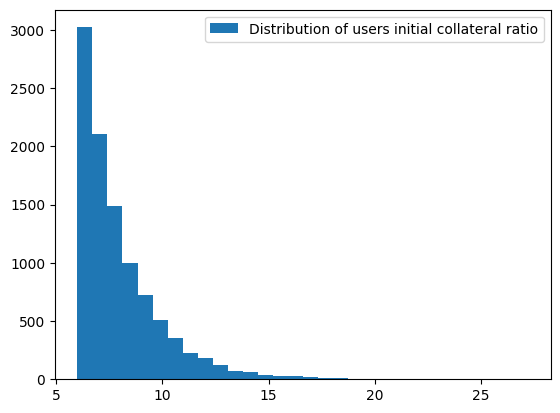

In [289]:
plt.hist(Users_ratio,label="Distribution of users initial collateral ratio",bins=30)
plt.legend()
plt.show()

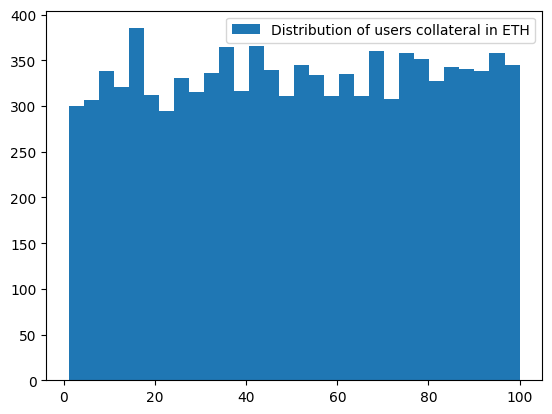

In [290]:
plt.hist(Users_collateral,label="Distribution of users collateral in ETH",bins=30)
plt.legend()
plt.show()

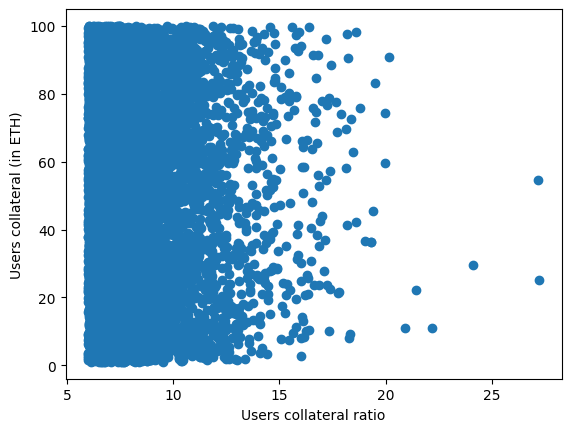

In [291]:
plt.scatter(Users_ratio,Users_collateral)
plt.xlabel("Users collateral ratio")
plt.ylabel("Users collateral (in ETH)")
plt.show()

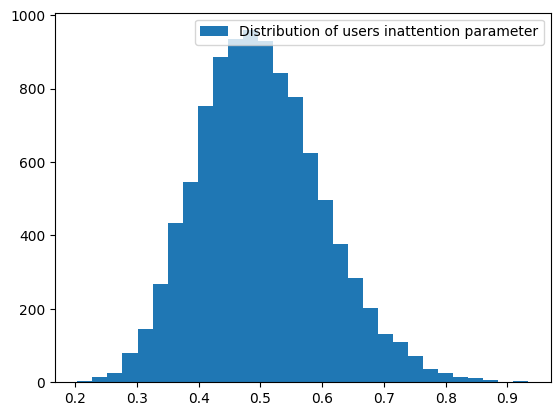

In [292]:
plt.hist(Users_inattention_parameter,label="Distribution of users inattention parameter",bins=30)
plt.legend()
plt.show()

In [293]:
""" Simulation routine """

time_period = 365
initial_base_fee = base_fee_extract[0]
protocol_TCR = []
liquidation_count = []
total_collateral = []

""" Troves initiation """

for i in range(Number_of_users):
    protocol.open_trove(Users_collateral[i],Users_debt[i],Users_ratio[i],Users_inattention_parameter[i],initial_base_fee)

protocol_TCR.append(protocol.total_collateral_ratio(initial_base_fee))
""" Time period simulation """

for j in range(time_period):
    """ Update the base fee """
    base_fee = base_fee_extract[j+1]

    """ Check for liquidations """
    liquidable_troves = protocol.check_for_liquidations(base_fee)

    """ Liquidate toxic troves """
    if len(liquidable_troves) >=1 :
        for k in range(len(liquidable_troves)):
            #protocol.liquidate_trove(liquidable_troves[k])
            pass

    """ Top-ups """
    for key,trove in protocol.troves.items() :
        if (trove.collateral_ratio(base_fee)>= trove.initial_ratio - trove.inattention_parameter) or (trove.collateral_ratio(base_fee)<=trove.initial_ratio + trove.inattention_parameter) :
            pass
        else :
            amount = trove.initial_ratio*trove.debt*base_fee*(10**(-3)) - trove.collateral
            protocol.add_collateral(amount,key)
    
    protocol_TCR.append(protocol.total_collateral_ratio(base_fee))
    liquidation_count.append(protocol.liquidation_count)
    total_collateral.append(protocol.total_collateral())


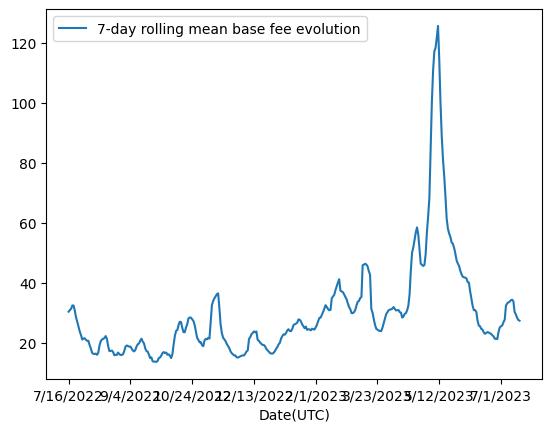

In [294]:
base_fee_extract.plot(label="7-day rolling mean base fee evolution")
plt.legend()
plt.show()

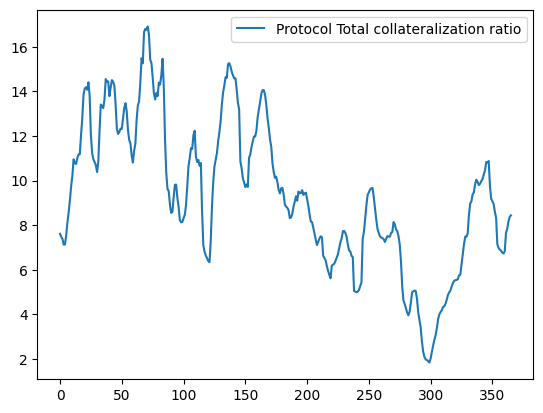

In [295]:
plt.plot(protocol_TCR,label="Protocol Total collateralization ratio")
plt.legend()
plt.show()